# Store Sales - Time Series Forecasting
## Practice Competition

In [1]:
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot

# Setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, MultiTaskLassoCV, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
import zipfile

## Paramters

In [2]:
random_state = 42

min_date_str = '2016'
max_date_str = '2017-08-15'

index_levels = ['store_nbr', 'family', 'date']

train_test_dtype = {
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32'
    }

holiday_dtype = {
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    }

stores_dtype = {
        'store_nbr': 'category',
        'city': 'category',
        'state': 'category',
        'type': 'category',
        'cluster': 'category',
    }

target_dtype = {'sales': 'float32'}

date_cols = ['date']


# Feature parameters
test_days = 16
lag_days = 16
xgb_n_estimators = 1000

## Load Data

In [3]:
with zipfile.ZipFile('../../res/data/store-sales-time-series-forecasting.zip', 'r') as z:
    
    # The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
    with z.open('train.csv') as f:
        train = pd.read_csv(
            f,
            usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
            dtype=train_test_dtype | target_dtype, 
            parse_dates=date_cols
        )
        train[date_cols[0]] = train.date.dt.to_period('D')
        train = train.set_index(index_levels).sort_index()
        
    # The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
    with z.open('test.csv') as f:
        test = pd.read_csv(f, dtype=train_test_dtype, parse_dates=date_cols)
        test[date_cols[0]] = test.date.dt.to_period('D')
        test = test.set_index(index_levels).sort_index()
    
    # Holidays and Events, with metadata
    with z.open('holidays_events.csv') as f:
        holidays_events = pd.read_csv(f, dtype=holiday_dtype, parse_dates=date_cols)
        holidays_events = holidays_events.set_index(date_cols[0]).to_period('D')
        
    # Store metadata, including city, state, type, and cluster.
    with z.open('stores.csv') as f:
        stores = pd.read_csv(f, dtype=stores_dtype)
        
    # Daily oil price. Includes values during both the train and test data timeframes.
    with z.open('oil.csv') as f:
        oil = pd.read_csv(f, dtype=stores_dtype)

## Data Summaries

In [4]:
average_sales = (
    train
    .groupby(date_cols[0]).mean()
    .squeeze()
    .loc[min_date_str:max_date_str]
)

## Function Definitions

In [5]:

def rmsle(y_true, y_pred):
    """Define root mean squared logarithmic error scoring function"""
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

def make_lags(ts, lags):
    df = pd.concat(
            {
                f'lag_{i}': ts.shift(i)
                for i in range(1, lags + 1)
            },
            axis=1)
    df = df.stack().stack()
    df.columns = ['_'.join(col[::-1]).strip() for col in df.columns.values]

    return df

## Boosted Hybrid

In [6]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
    def fit(self, X_1, X_2, y):
        # Save column names for predict method
        self.y_columns = y.columns
        
        self.model_1.fit(X_1, y)
        
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        
        # clip model_1 so model_2 does not have to correct...
        y_resid = y - y_fit.clip(0.0)
        y_resid = y_resid.stack().stack().squeeze() # wide to long
        self.model_2.fit(X_2, y_resid)

        
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid
    
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().stack().squeeze()  # wide to long

        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack().unstack()  # long to wide
    
    def predict_w_lag(self, X_1, X_2, test_days, le_store_nbr, le_family):
        count = 0
        y_pred_dfs = []
        for idx, row in X_1.iterrows():
            y_pred_1 = pd.DataFrame(
                self.model_1.predict(row.values.reshape(1, -1)),
                index=[idx], columns=self.y_columns,
            )
            
            # y_pred_1 = y_pred_1.stack().stack().squeeze()  # wide to long
            y_pred_2 = self.model_2.predict(X_2.loc[idx])
            
            y_pred = y_pred_1 + y_pred_2
            y_pred_dfs.append(y_pred)
                        
            y_temp = y_pred.stack(['store_nbr', 'family']).reset_index('store_nbr')
            y_temp['store_nbr'] = le_store_nbr.transform(y_temp['store_nbr'])
            y_temp = y_temp.reset_index('family')
            y_temp['family'] = le_family.transform(y_temp['family'])

            # start = 2
            for offset in range(1, test_days - count):
                # If 'date' is an index, reset it to make it a column
                df1 = y_temp.loc[idx].reset_index()
                df2 = X_2.loc[idx+offset].reset_index()

                # Renaming column 0 to 'sales_lag_1_temp' in df1_subset
                df1_subset = df1[['family', 'store_nbr', 'sales']].rename(columns={'sales': 'sales_lag_temp'})

                # Merging df2 with df1_subset
                df2 = pd.merge(df2, df1_subset, on=['family', 'store_nbr'], how='left')

                # Updating 'sales_lag_1' in df2 with the values from 'sales_lag_1_temp'
                df2[f'sales_lag_{offset}'] = df2['sales_lag_temp']

                # Dropping the 'sales_lag_1_temp' column from df2
                df2.drop(columns=['sales_lag_temp'], inplace=True)
                
            count += 1
        y_pred_df = pd.concat(y_pred_dfs)
        return y_pred_df.xs('sales', level=0, axis=1, drop_level=True)

## Training Data with features

In [7]:
# Target series

y = train.unstack(['store_nbr', 'family']).loc[min_date_str:max_date_str, ['sales']]

# X_1: Features for Regression
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X_1 = dp.in_sample()

# National holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National']")
    .loc[:, ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

X_holidays = pd.get_dummies(holidays)
X_holidays = X_holidays.groupby(X_holidays.index).sum()

X_1 = X_1.join(X_holidays, on='date', how='left').fillna(0.0)

# TODO: add regional and local holidays

# X_2: Features for XGBoost
X_2 = train.unstack(['store_nbr', 'family']).loc[min_date_str:max_date_str].drop('sales', axis=1).stack().stack()  # 
# onpromotion feature

X_new = make_lags(y, lag_days)#.stack().stack()

X_2 = X_2.join(X_new)

# Label encoding for 'store_nbr'
le_store_nbr = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('store_nbr')
X_2['store_nbr'] = le_store_nbr.fit_transform(X_2['store_nbr'])

# Label encoding for 'family'
le_family = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le_family.fit_transform(X_2['family'])


# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

# # add target lags
# make_lags(y, 'sales', 2)
X_2 = X_2.fillna(0.0)


In [8]:
model = BoostedHybrid(LinearRegression(), XGBRegressor(n_estimators=xgb_n_estimators, random_state=random_state))
model.fit(X_1, X_2, y)
y_fit = model.predict(X_1, X_2)
y_fit = y_fit.clip(0.0)
rmsle(y, y_fit)

0.6207060610398926

In [ ]:
# tscv = TimeSeriesSplit(n_splits=5)  # Or another appropriate number of splits
# 
# model_1 = RidgeCV(cv=tscv)
# model_lasso = BoostedHybrid(model_1, XGBRegressor(n_estimators=xgb_n_estimators))
# model_lasso.fit(X_1, X_2, y)
# y_fit = model_lasso.predict(X_1, X_2)
# y_fit = y_fit.clip(0.0)
# rmsle(y, y_fit)

## Test features

In [16]:

# Create features for test set
X_test_1 = dp.out_of_sample(steps=test_days)
X_test_1.index.name = 'date'

X_test_1 = X_test_1.join(X_holidays, on='date', how='left').fillna(0.0)

X_test_2 = test[['onpromotion']]

new_index = pd.period_range(start=y.index[0], end=y.index[-1] + pd.Timedelta(days=lag_days), freq='D', name='date')

X_new = make_lags(y.reindex(new_index), test_days)#.stack().stack()

X_test_2 = X_test_2.join(X_new, how='left')
X_test_2

# Label encoding for 'store_nbr'
le_store_nbr = LabelEncoder()  # from sklearn.preprocessing
X_test_2 = X_test_2.reset_index('store_nbr')
X_test_2['store_nbr'] = le_store_nbr.fit_transform(X_test_2['store_nbr'])

# Label encoding for 'family'
le_family = LabelEncoder()  # from sklearn.preprocessing
X_test_2 = X_test_2.reset_index('family')
X_test_2['family'] = le_family.fit_transform(X_test_2['family'])

# Label encoding for seasonality
X_test_2["day"] = X_test_2.index.day  # values are day of the month
X_test_2

y_pred = model.predict_w_lag(X_test_1, X_test_2.copy(), test_days, le_store_nbr, le_family)
# y_pred = y_pred.clip(0.0)
y_pred
# # y_submit = pd.DataFrame(y_submit, index=y_submit.index, columns=y_submit.columns)
# y_submit = y_pred.stack(['store_nbr', 'family']).to_frame()
# # y_submit = y_submit.stack()
# y_submit.rename(columns={0: 'sales'}, inplace=True)
# # y_submit = y_submit.reorder_levels(['store_nbr', 'family', 'date'])
# y_submit = y_submit.join(test.id).reindex(columns=['id', 'sales'])
# # y_submit.to_csv('submission.csv', index=False)
# y_submit


store_nbr             1                                                      \
family       AUTOMOTIVE    BABY CARE       BEAUTY    BEVERAGES        BOOKS   
2017-08-16     4.302948     0.426790     9.147702  2539.772289     0.310337   
2017-08-17   842.516622  1885.329834   830.742726  1902.098514  1518.562863   
2017-08-18  1376.931060  2487.330322  1288.065713  2687.362010  2191.541260   
2017-08-19  2150.910016  2706.613037  1887.736245  2786.882748  2237.955392   
2017-08-20  4504.539845  4067.530029  4133.118176  2895.340991  3719.306808   
2017-08-21    52.749475   -42.745182  -185.534842  2071.521838  -178.324696   
2017-08-22  -261.572437  -224.443970  -127.505862  3411.727822  -537.260900   
2017-08-23  -183.977006   -69.290421   142.543327  3234.740396  -528.580048   
2017-08-24  2552.423358  2771.093506  2545.310844  3396.600573  2218.817199   
2017-08-25  2038.546048  2204.357666  2035.411699  2628.331435  1748.356598   
2017-08-26  -378.776242  -135.351959   -19.891662  3247.121213  -386.249906   
2017-08-27  1291.596892  1251.790283  1420.231366  5604.691941  1081.923449   
2017-08-28  1235.200460  1230.968018  1569.663907  5786.910146  1287.847936   
2017-08-29  2739.120250  2138.602295  2415.138199  4895.346499  2302.121827   
2017-08-30  3723.416006  3200.592041  3753.177438  4926.101179  3380.322568   
2017-08-31  3949.117883  3955.884033  3432.220680  5289.587730  4097.888804   

store_nbr                                                                    \
family     BREAD/BAKERY  CELEBRATION     CLEANING        DAIRY         DELI   
2017-08-16   458.487207    16.912994   881.071031   981.633349   154.624369   
2017-08-17   691.639040   495.902416   101.355576   262.640669   126.033845   
2017-08-18   961.053419  1095.461477  1531.036556  1731.741473  -435.665413   
2017-08-19  3035.033055  1705.053936  1236.856124  1339.411184   936.369315   
2017-08-20  4797.364797  4196.599217  4346.619603  5276.034176  3146.261144   
2017-08-21  1290.849851   -29.123458  2477.548753  1459.370051   147.266304   
2017-08-22   360.962218  -518.507229  1819.594980  1352.441570  -379.647538   
2017-08-23   607.817768  -628.083068  1680.636330  1984.822620   313.564856   
2017-08-24  2035.330356  2064.103359  2693.730637  2430.177246  1998.583776   
2017-08-25  1505.375169  1558.272194  1859.460445  2215.887559  2152.092640   
2017-08-26   474.740926  -437.673936  1537.988836  2546.451211   251.648142   
2017-08-27  1736.086819  1288.881554  2839.818716  3279.187687  2213.612642   
2017-08-28  2657.410640  1406.505743  4161.834945  4640.244988  2630.694797   
2017-08-29  4017.549378  2823.731748  4893.563084  5041.218516  4716.991717   
2017-08-30  4897.027607  3838.677490  5323.136496  4522.646008  3426.132761   
2017-08-31  4827.083486  4253.094478  3796.278992  5365.513052  4245.979387   

store_nbr   ...            9                                          \
family      ...    MAGAZINES        MEATS PERSONAL CARE PET SUPPLIES   
2017-08-16  ...     3.170115   321.437996    414.561797     7.490346   
2017-08-17  ...    35.005270  -750.104611   -563.019526   293.075471   
2017-08-18  ...  1358.152890  1412.588517   1298.679111  1671.283995   
2017-08-19  ...   882.853548  2152.084201   2455.454874  1128.555118   
2017-08-20  ...  2244.309362  3366.517286   4587.325857  2523.695486   
2017-08-21  ...  -344.635029   -44.877016    383.966313  -239.616809   
2017-08-22  ...   491.905171   658.139324    796.148654   609.307946   
2017-08-23  ...   451.191394   -60.605685     51.294384   437.857980   
2017-08-24  ...  2809.338738  2859.311297   1545.515823  2765.257312   
2017-08-25  ...   237.577843   331.025821    602.978062   220.434512   
2017-08-26  ... -1048.535135  -389.679588   1340.139816 -1046.741576   
2017-08-27  ...    91.300278  1094.064434   1759.354797   109.184799   
2017-08-28  ...  1313.127336  2061.365630   2469.672095  1320.748876   
2017-08-29  ...  2730.279701  3447.097181   2996.653033  2771.469867   
20

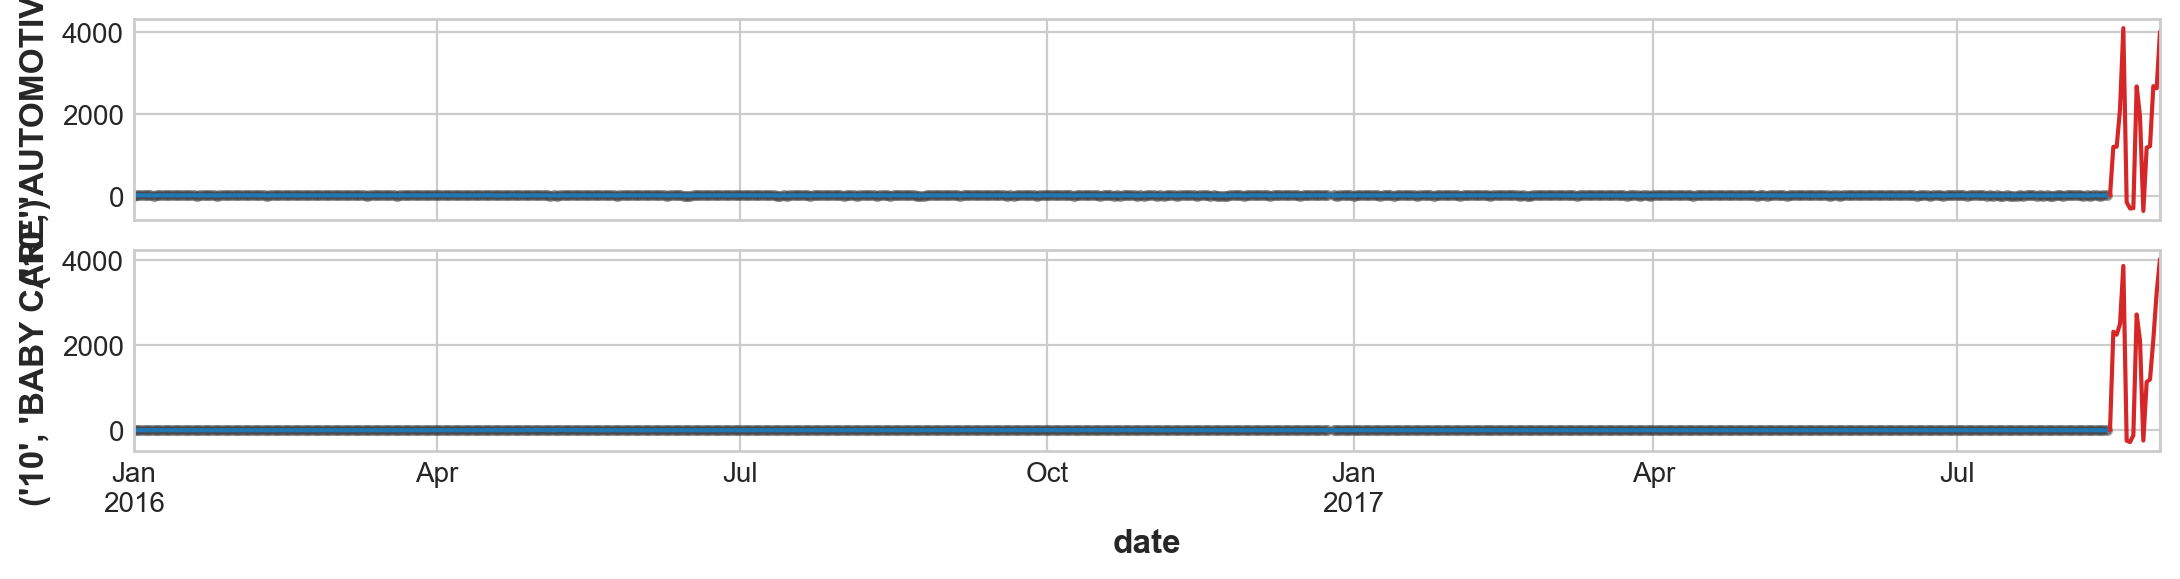

In [17]:
y_unstack = y.loc(axis=1)['sales']

y_fit_unstack = y_fit #.loc(axis=1)['sales'].unstack(['store_nbr', 'family'])

store_families = y_pred.columns[33:35:1]

axs = y_unstack.loc(axis=1)[store_families].plot(
    subplots=True, sharex=True, figsize=(11, 3), **plot_params, alpha=0.5,
)
_ = y_fit_unstack.loc(axis=1)[store_families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[store_families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, store_families):
    ax.legend([])
    ax.set_ylabel(family)

In [13]:
model_1 = LinearRegression()
model_1.fit(X_1, y)

y_pred = pd.DataFrame(
            model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

# y_pred.clip(0.0)

model_2 = XGBRegressor(n_estimators=100)
# clip model_1 so model_2 does not have to correct...
y_resid = y - y_pred.clip(0.0)
y_resid = y_resid.stack().stack().squeeze() # wide to long
# model_2.fit(X_2, y_resid)
y_resid

date        family      store_nbr
2016-01-01  AUTOMOTIVE  1            -0.669320
                        10           -0.647115
                        11            0.000000
                        12            0.000000
                        13            0.000000
                                       ...    
2017-08-15  SEAFOOD     54            0.201065
                        6            11.698191
                        7             3.308549
                        8            -8.831378
                        9             1.440042
Name: sales, Length: 1054944, dtype: float64

In [14]:
X_2

,family,store_nbr,onpromotion,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14,sales_lag_15,sales_lag_16,day
date,,,,,,,,,,,,,,,,,,,,
2016-01-01,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2016-01-01,0,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2016-01-01,0,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2016-01-01,0,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2016-01-01,0,4,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,32,49,0,0.000000,2.000000,1.000000,0.000000,2.000000,4.000000,12.000000,0.000000,0.000000,3.000000,0.000,5.000000,3.000000,3.000000,4.000000,4.000000,15
2017-08-15,32,50,0,37.879002,58.470001,35.029999,52.797001,18.448999,30.630001,30.243999,36.591999,50.847000,49.216999,48.541,20.579000,47.934002,32.584000,37.934002,47.982998,15
2017-08-15,32,51,0,47.977001,33.647999,42.545002,40.477001,32.756001,48.764999,54.424000,39.996002,28.841999,41.153000,65.166,27.581001,49.229000,40.718998,45.745998,42.139999,15
